In [36]:
import pandas as pd
import numpy as np
import scipy
from matplotlib import pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [37]:
df_regLen#check missing values
def num_missing(x):
    return sum(x.isnull())

In [38]:
-

SyntaxError: invalid syntax (<ipython-input-38-0a1f21a34173>, line 1)

In [39]:
def plot_clustered_ts_part(timeSeries, k,method, metric,n, anim, plot = True):
    %matplotlib inline
    from scipy.cluster.hierarchy import fcluster, linkage
    import math
    import time

    Z = linkage(timeSeries.T[:n].T,  method=method, metric=metric)
    # k Number of clusters I'd like to extract
    results = fcluster(Z, k, criterion='maxclust')
    #print(results)
    # check the results
    s = pd.Series(results)
    clusters = s.unique()
    if anim == True:
        %matplotlib

    fig = plt.figure(1, figsize = (15,10))
    for i, c in enumerate(clusters):

        cluster_indeces = s[s==c].index

        if plot:
            with plt.style.context(('bmh')):
                x = math.ceil(k/2)
                ax = fig.add_subplot(x,2,i+1)
                if anim == True:
                    axes = fig.add_subplot(x,2,i+1)

                    for cluster_index in range(len(cluster_indeces)):
                        axes = plt.gca()
                        limmax = 3
                        limmin = -3
                        axes.set_ylim(limmin, limmax)
                        plt.plot(timeSeries.T.iloc[:,cluster_indeces[cluster_index]], marker = ".",label = cluster_indeces[cluster_index])
                        plt.draw()
                        plt.pause(0.1)
                        
                        #plt.legend(frameon=False, loc='lower right', ncol=2)

                else:
                    with plt.style.context(('bmh')):
                        x = math.ceil(k/2)
                        ax = fig.add_subplot(x,2,i+1)


                        %matplotlib inline
                        for cluster_index in range(len(cluster_indeces)):
                                
                            axes = plt.gca()
                            limmax = 3
                            limmin = -3
                            axes.set_ylim(limmin, limmax)
                            ax.plot(timeSeries.T.iloc[:,cluster_indeces[cluster_index]], marker = ".",label = cluster_indeces[cluster_index])



        else:
            print("Cluster %d - number of entries %d" % (c, len(cluster_indeces)))
    return results



In [40]:
# %load plot_heatmap.py
def plot_heatmap(timeSeries, best_method, best_metric):
    mask = timeSeries.isnull().T
    with sns.axes_style("white"):
        ax = sns.clustermap(timeSeries.T.fillna(0), metric=best_metric,method=best_method, col_cluster = False,figsize=(17,15),mask = mask)
        plt.show()


## advanced heatmap with annotation

def print_heatmap2(timeSeries, user_cycle_df, cycle_length, metric, method, first_cycle = True):

    import seaborn as sns; sns.set(color_codes=True)

    if cycle_length == "all":
        users = user_cycle_df[["user","cycle_index","cycle_number"]]
        users = users.set_index(users.cycle_index)
        figsize = (15,15)

    else:
        users = user_cycle_df[user_cycle_df.cycle_length == cycle_length][["user","cycle_index","cycle_number"]]
        users = users.set_index(users.cycle_index)
        figsize = (15,15)



    max_cycle_numbers = len(users.cycle_number.unique())-9

    colors = "ryyggccbb"+("k"*max_cycle_numbers)

    lut = dict(zip(users.user.unique(), sns.hls_palette(len(set(users.user)),l=0.4)))
    row_colors = users.user.map(lut).rename("user")

    lut2 = dict(zip(sorted(users.cycle_number.unique()), colors))
    
    row_colors2 = users.cycle_number.map(lut2).rename("first cycle")
    
    row_color = [row_colors2, row_colors]
    if first_cycle == False:
        row_color = row_colors

    mask = timeSeries.isnull()
    with sns.axes_style("white"):
        ax = sns.clustermap(timeSeries.fillna(0),
                    metric=metric,method=method,
                    col_cluster = False,
                    figsize=figsize,
                    row_colors = row_color,
                    mask = mask,
                    )
        plt.setp(ax.ax_heatmap.get_yticklabels(), rotation=0)  # For y axis
        plt.setp(ax.ax_heatmap.get_xticklabels(), rotation=90) # For x axis
        plt.title('', fontsize=12)
        plt.suptitle(method+"-"+metric+" clustered cylces ("+str(cycle_length)+" Days)", fontsize=20)
        plt.legend(bbox_to_anchor=(1, 1), loc=2)
        plt.savefig('heatmap2.png')


In [41]:
# %load plot_dendro.py
# Do the clustering
def plot_dendro(timeSeries, method, metric, k, feature, cycle_length):
    Z = linkage(timeSeries,  method=method, metric=metric)
    with plt.style.context(('bmh')):
    # Plot dendogram
        set_link_color_palette(['m', 'c', 'y', 'k'])
        d = plt.figure(figsize=(15, 7))
        plt.title(str(feature+" "+str(cycle_length)+" Days "+str(method)+" "+str(metric)+" "+str(k)))
        plt.xlabel('cycle index')
        plt.ylabel('distance')
        dendrogram(Z,
            leaf_rotation=90., # rotates the x axis labels\
            leaf_font_size=8., # font size for the x axis labels\
            show_contracted=True)
    return d, Z


In [42]:
# %load cycle_transform.py
def cycle_transform(df, value, save = True):

    value_ = df[["cycle_day", value, "cycle_index"]]
    print(sorted(value_.cycle_index.unique()))

    value_zero = value_.pivot_table(index = "cycle_day", columns="cycle_index", values = value_).fillna(0)
    #print("value_zero:",value_zero)
    value_nan = value_.pivot_table(index = "cycle_day", columns="cycle_index", values = value_)

    if save == True:
        value_zero.to_csv("Data/"+value+"_zero.csv")
        value_nan.to_csv("Data/"+value+"_nan.csv")
    return value_zero, value_nan

In [43]:
def cluster_order(clusters, ts):
    cluster = {"cluster" : clusters, "cycle_index":ts.T.columns}
    cluster = pd.DataFrame(cluster)
    cluster = cluster.sort_values(by="cluster")

    return cluster

In [44]:
def heatmap_ordered(clustered_df, timeSeries,colormap):
    %matplotlib inline
    cols = list(clustered_df["cycle_index"])
    t = timeSeries.T
    new = t[cols]

    cluster_cycleindex = clustered_df.set_index("cycle_index")

    fig = plt.figure(figsize=(15,30))  
    
    if colormap =="no":
        colormap = "rocket"
    lut = dict(zip(cluster_cycleindex.cluster.unique(), sns.hls_palette(len(set(cluster_cycleindex.cluster)),l=0.4)))
    row_colors = cluster_cycleindex.cluster.map(lut).rename("cluster")
    with sns.axes_style("white"):
        ax = sns.clustermap(new.T, 
                            row_colors = row_colors,
                            row_cluster=False, 
                            col_cluster=False, 
                            figsize = (15,15), 
                            robust = True,
                            cmap = colormap
                           )
        plt.setp(ax.ax_heatmap.get_yticklabels(), rotation=0)  # For y axis
        plt.setp(ax.ax_heatmap.get_xticklabels(), rotation=90) # For x axis


## Data

In [6]:
#br29_norm = pd.read_csv("Data/br_29_norm.csv")
#hr29_norm = pd.read_csv("Data/hr_29_norm.csv")
#st29_norm = pd.read_csv("Data/st_29_norm.csv")

df_regLen = pd.read_csv("Data/regLen.csv").drop(["Unnamed: 0", "index"], axis = 1)

groupby_cycles = df_regLen.groupby(["cycle_index","user","cycle_number"]).mean()
user_cycle_df = pd.DataFrame(groupby_cycles.reset_index()[["cycle_index", "user", "cycle_number", "cycle_length"]])
user_cycle_df["cycle_length"] = user_cycle_df["cycle_length"].astype(int)

#missing days interpolated
md = pd.read_csv("Data/missingdays_interpolated.csv")
#complete cycles
cc = pd.read_csv("Data/data_clean2.csv")

#example
hr29_norm_zero, hr29_norm_nan = cycle_transform(md[md.cycle_length == 29], "hr_norm", True)
hr29_norm_zero2, hr29_norm_nan2 = cycle_transform(cc[cc.cycle_length == 29], "hr_norm", True)


hr_zero, hr_nan = cycle_transform(md[md.cycle_length == 29], "hr", True)
hr_zero2, hr_nan2 = cycle_transform(cc[cc.cycle_length == 29], "hr", True)

hr29_norm_nan_md_cc = pd.concat([hr29_norm_nan, hr29_norm_nan2], axis=1, join_axes=[hr29_norm_nan.index])
hr29_nan_md_cc = pd.concat([hr_nan, hr_nan2], axis=1, join_axes=[hr29_norm_nan.index])
hr29_zero_md_cc = pd.concat([hr_zero, hr_zero2], axis=1, join_axes=[hr29_norm_nan.index])



#user 407
#example
hr407_norm_zero, hr407_norm_nan = cycle_transform(md[md.user == 407], "hr_norm", True)
hr407_norm_zero2, hr407_norm_nan2 = cycle_transform(cc[cc.user == 407], "hr_norm", True)

hr407_zero, hr407_nan = cycle_transform(md[md.user == 407], "hr", True)
hr407_zero2, hr407_nan2 = cycle_transform(cc[cc.user == 407], "hr", True)

hr407_norm_nan_md_cc = pd.concat([hr407_norm_nan, hr407_norm_nan2], axis=1, join_axes=[hr407_norm_nan.index])
hr407_nan_md_cc = pd.concat([hr407_nan, hr407_nan2], axis=1, join_axes=[hr407_norm_nan.index])
hr407_zero_md_cc = pd.concat([hr407_zero, hr407_zero2], axis=1, join_axes=[hr407_norm_nan.index])



[23, 26, 30, 48, 54, 83, 84, 93, 99, 147, 196, 209, 225, 250, 282, 286, 287, 352, 360, 367, 379, 393, 452, 468, 475, 496, 498, 500, 504, 541, 548, 576, 604, 629, 712, 716, 734, 790]
[22, 24, 27, 52, 57, 81, 126, 175, 210, 211, 214, 230, 236, 253, 277, 482, 490, 542, 625, 633, 651, 692, 719, 725, 780, 782]
[23, 26, 30, 48, 54, 83, 84, 93, 99, 147, 196, 209, 225, 250, 282, 286, 287, 352, 360, 367, 379, 393, 452, 468, 475, 496, 498, 500, 504, 541, 548, 576, 604, 629, 712, 716, 734, 790]
[22, 24, 27, 52, 57, 81, 126, 175, 210, 211, 214, 230, 236, 253, 277, 482, 490, 542, 625, 633, 651, 692, 719, 725, 780, 782]
[31, 32, 36, 38, 39, 40, 41, 43, 44, 45, 46, 47]
[33, 34, 35, 37, 42]
[31, 32, 36, 38, 39, 40, 41, 43, 44, 45, 46, 47]
[33, 34, 35, 37, 42]


# bray curtis & complete

In [45]:
feature = "Heart Rate (z-score)"
%matplotlib inline
cycle_length = "29"
timeSeries = hr29_norm_nan_md_cc.fillna(0)
ts = timeSeries.T.reset_index().drop("level_0", axis =1).set_index("cycle_index")
k = 6
method = "complete"
metric = "braycurtis"
#plot_dendro(timeSeries, method, metric, k, feature, cycle_length)
clusters = plot_clustered_ts(ts, k, method, metric, anim=True, plot = True)
plt.savefig(method+"-"+metric+" clustered cylces ("+str(cycle_length)+" Days).png")

NameError: name 'plot_clustered_ts' is not defined

In [46]:
timeSeries = hr29_zero_md_cc
ts = timeSeries.T.reset_index().drop("level_0", axis =1).set_index("cycle_index")
plot_clustered_ts_notnorm(ts, k, method, metric, clusters, plot = True)


NameError: name 'clusters' is not defined

IndexError: index 27 is out of bounds for axis 1 with size 26

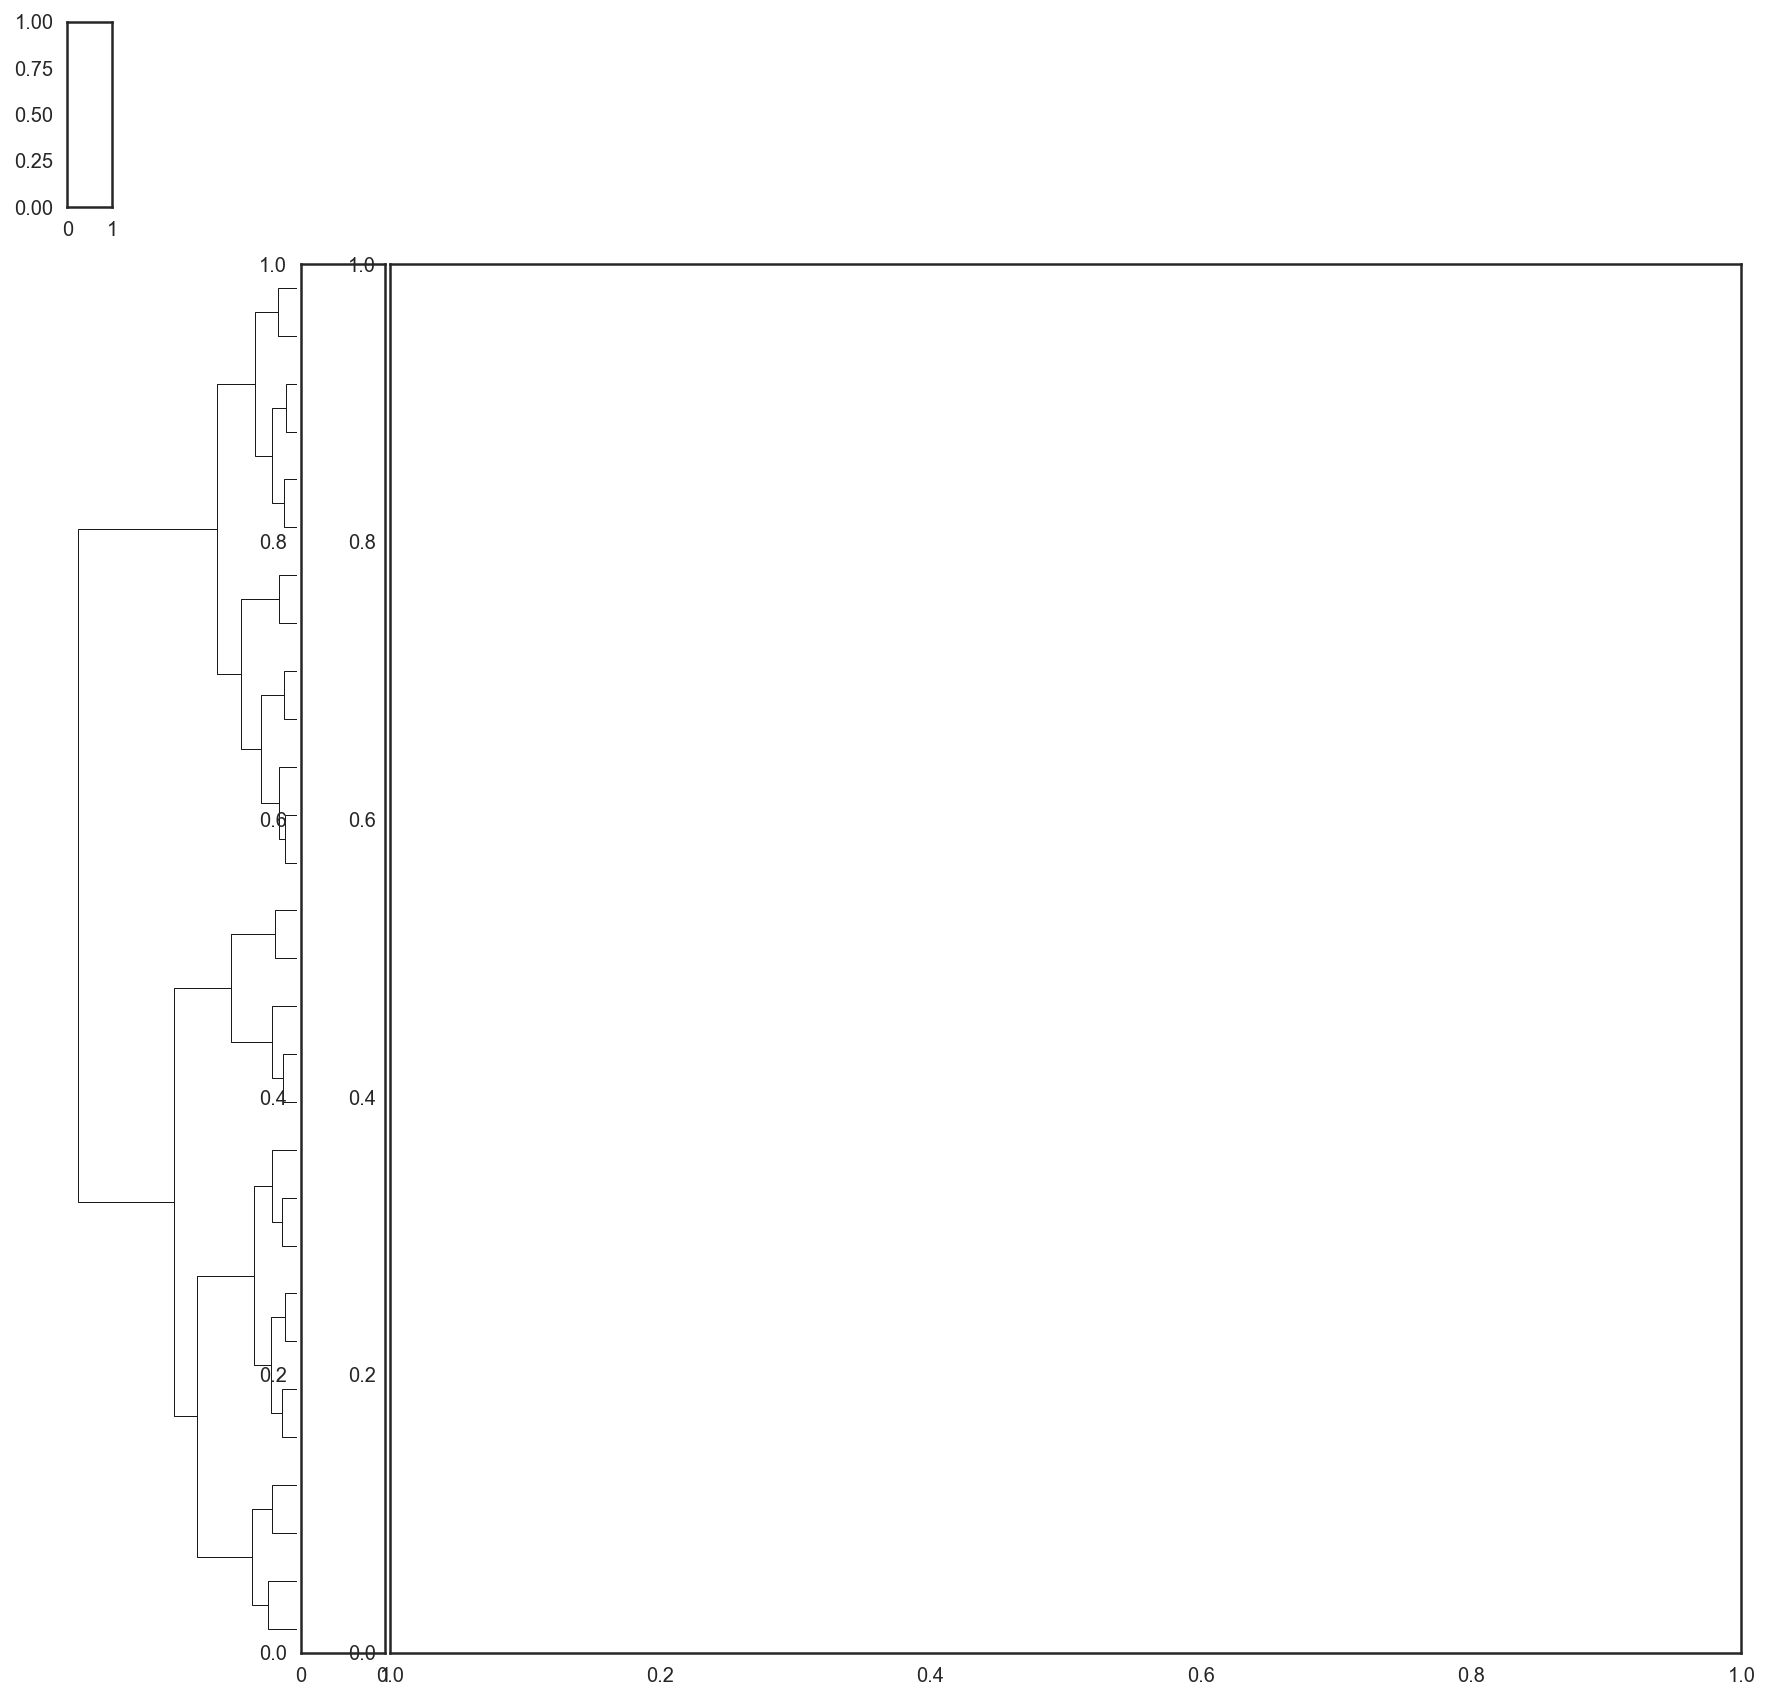

In [47]:
cycle_length = int(cycle_length)
timeSeries = hr29_norm_nan_md_cc.fillna(0)
ts = timeSeries.T.reset_index().drop("level_0", axis =1).set_index("cycle_index")
print_heatmap2(timeSeries, user_cycle_df, cycle_length, metric, method, first_cycle = True)

plt.savefig('hr/single_euclidean_29_hr.png', bbox_inches='tight')

In [48]:
#cycle_indeces cluster sorted
clustered_bray_complete = cluster_order(clusters, ts)


NameError: name 'clusters' is not defined

In [49]:
#heatmap of the original feature values sorted by clusters
heatmap_ordered(clustered_bray_complete, hr29_nan_md_cc, "no")
plt.savefig('hr/single_euclidean_29_hr_CLUSTER_.png', bbox_inches='tight')

NameError: name 'clustered_bray_complete' is not defined

# ward & euclidean

In [50]:
feature = "Heart Rate (z-score)"
%matplotlib inline
cycle_length = "29"
timeSeries = hr29_norm_nan_md_cc.fillna(0)
ts = timeSeries.T.reset_index().drop("level_0", axis =1).set_index("cycle_index")
k = 6
method = "ward"
metric = "euclidean"
#plot_dendro(timeSeries, method, metric, k, feature, cycle_length)
clusters = plot_clustered_ts(ts, k, method, metric, anim=True, plot = True)
print(clusters)
plt.savefig(method+"-"+metric+" clustered cylces ("+str(cycle_length)+" Days).png")

NameError: name 'plot_clustered_ts' is not defined

IndexError: index 27 is out of bounds for axis 1 with size 26

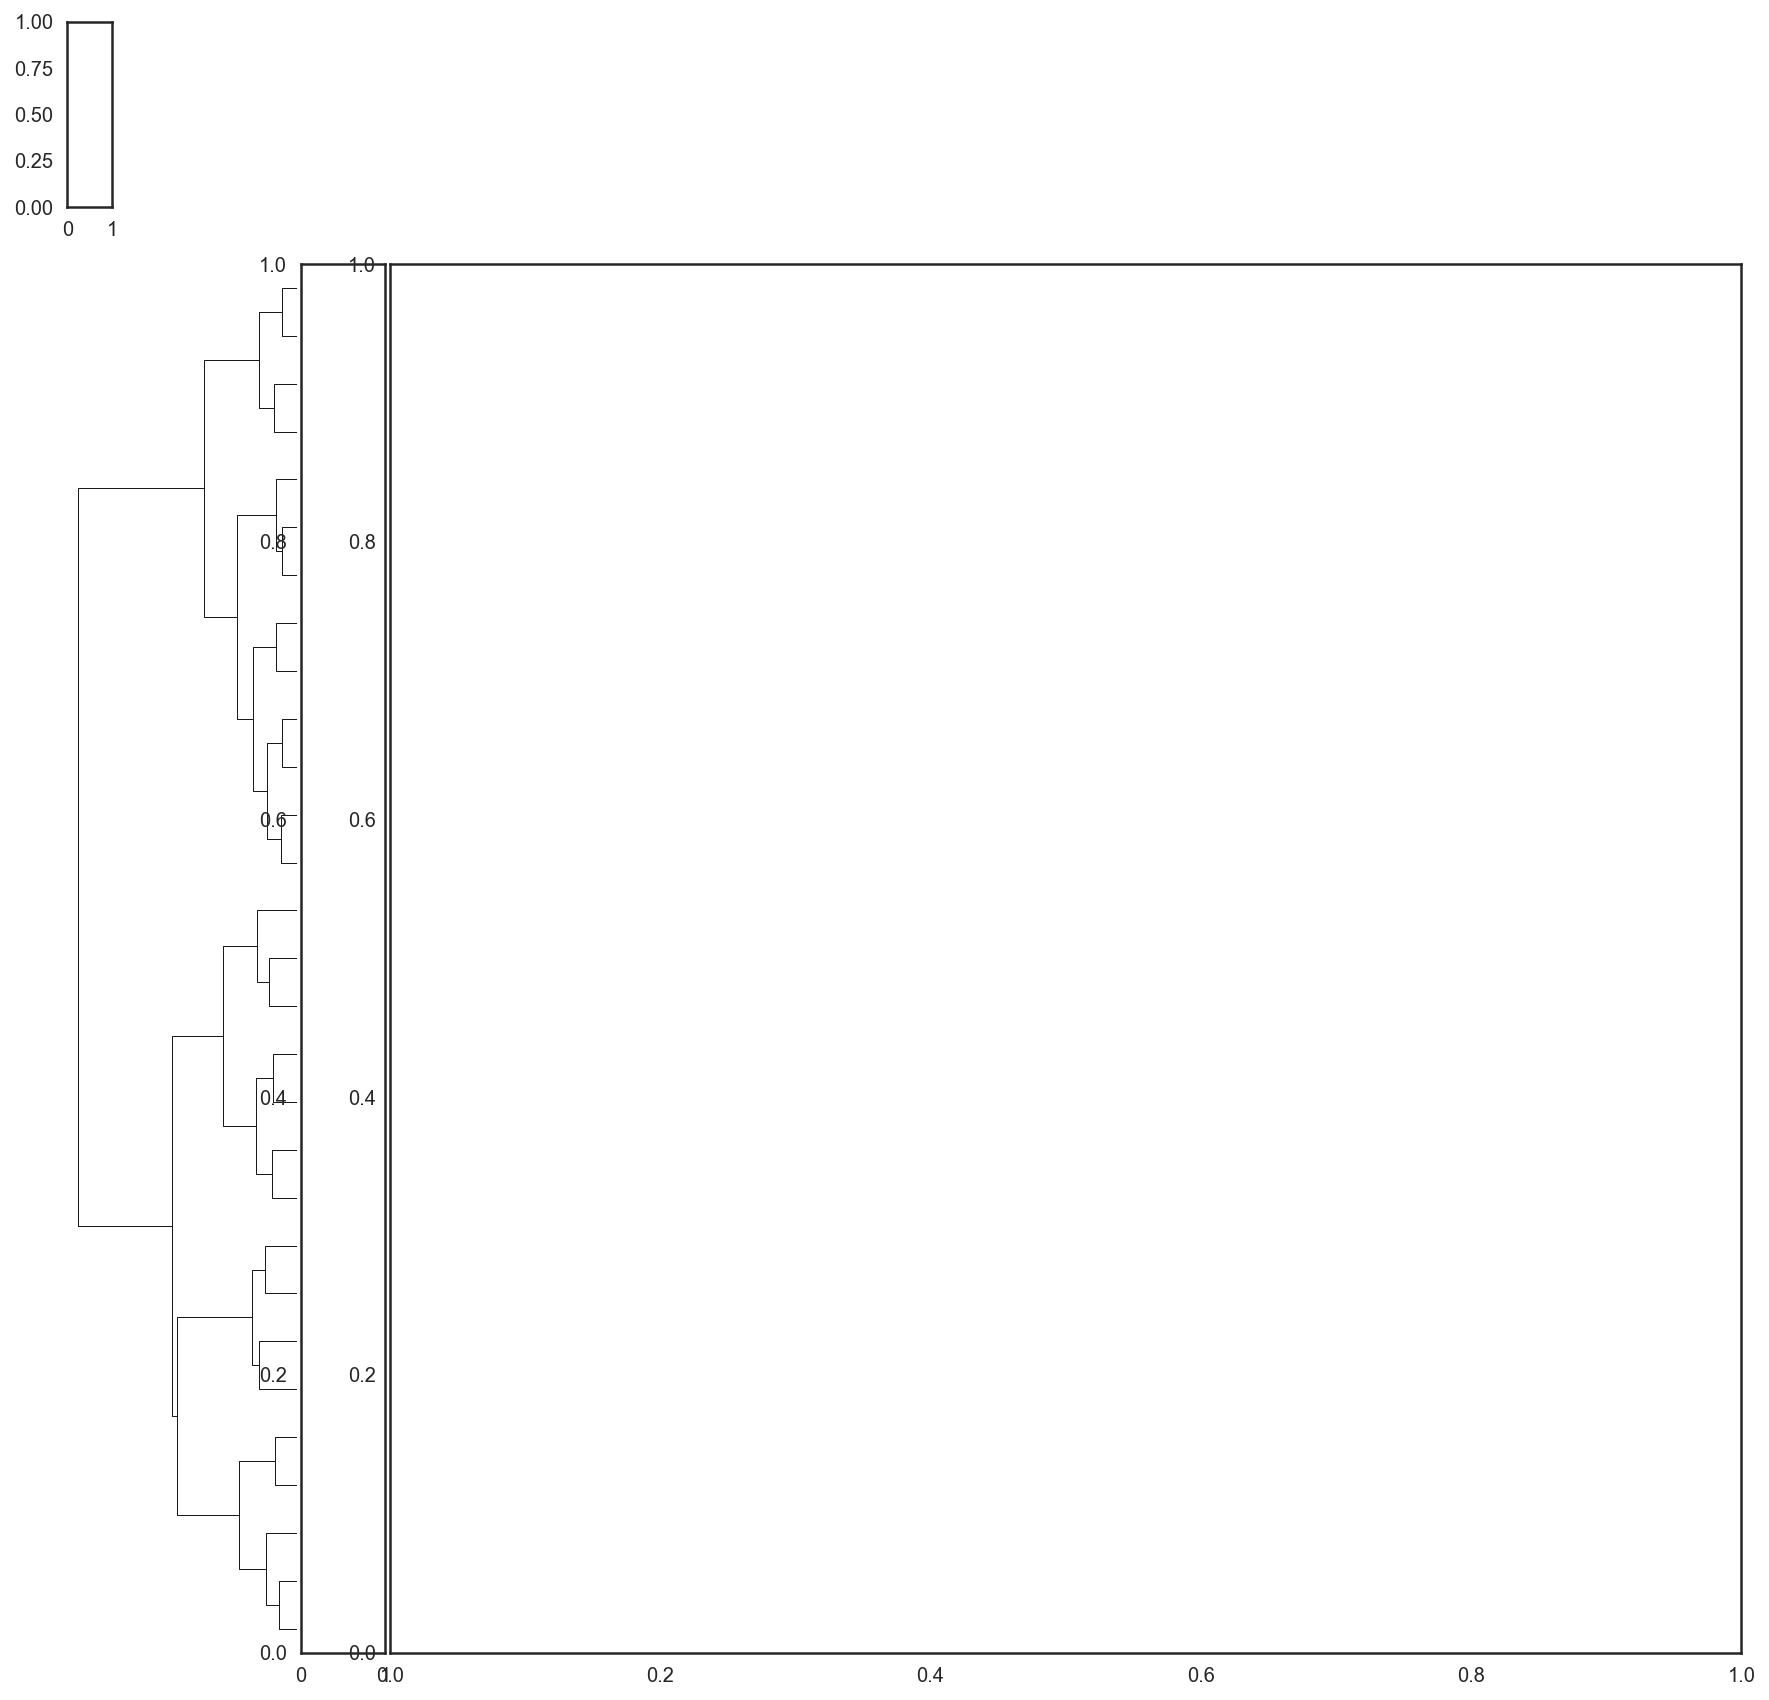

In [51]:
cycle_length = int(cycle_length)
print_heatmap2(timeSeries, user_cycle_df, cycle_length, metric, method, first_cycle = True)

plt.savefig('hr/complete_braycurtis_29_hr.png', bbox_inches='tight')

In [52]:
#cycle_indeces cluster sorted
clustered_bray_complete = cluster_order(clusters, ts)

#heatmap of the original feature values sorted by clusters
heatmap_ordered(clustered_bray_complete, hr29_nan_md_cc, "no")
plt.savefig('hr/ward_euclidean_29_hr_CLUSTER_.png', bbox_inches='tight')

NameError: name 'clusters' is not defined

In [53]:
clusters = plot_clustered_ts(ts, k, method, metric, anim=True, plot = True)

NameError: name 'plot_clustered_ts' is not defined

In [54]:
feature = "Heart Rate (z-score)"
%matplotlib inline
cycle_length = "29"
timeSeries = hr29_zero_md_cc
ts = timeSeries.T.reset_index().drop("level_0", axis =1).set_index("cycle_index")
k = 6
method = "ward"
metric = "euclidean"
#plot_dendro(timeSeries, method, metric, k, feature, cycle_length)
clusters = plot_clustered_ts(ts, k, method, metric, anim=True, plot = True)
print(clusters)

NameError: name 'plot_clustered_ts' is not defined

In [55]:
# %load plot_clustered_ts.py
def plot_clustered_ts_notnorm(timeSeries, k,method, metric,clusters, plot = True):
    %matplotlib inline
    from scipy.cluster.hierarchy import fcluster, linkage
    import math
    import time

    results = clusters
    s = pd.Series(results)
    clusters = s.unique()

    fig = plt.figure(1, figsize = (15,10))
    for i, c in enumerate(clusters):

        cluster_indeces = s[s==c].index

        if plot:
            with plt.style.context(('bmh')):
                x = math.ceil(k/2)
                ax = fig.add_subplot(x,2,i+1)

                for cluster_index in range(len(cluster_indeces)):
                                
                    axes = plt.gca()
                    limmax = timeSeries.T.iloc[:,cluster_indeces[cluster_index]].max().max()
                    limmin = timeSeries.T.iloc[:,cluster_indeces[cluster_index]].min().min()
                    axes.set_ylim(40, 80)
                    ax.plot(timeSeries.T.iloc[:,cluster_indeces[cluster_index]], marker = ".",label = cluster_indeces[cluster_index])

        else:
            print("Cluster %d - number of entries %d" % (c, len(cluster_indeces)))

    return results

In [56]:
timeSeries = hr29_zero_md_cc
ts = timeSeries.T.reset_index().drop("level_0", axis =1).set_index("cycle_index")
plot_clustered_ts_notnorm(ts, k, method, metric, clusters, plot = True)

NameError: name 'clusters' is not defined

### 407

In [57]:
feature = "Heart Rate (z-score)"
%matplotlib inline
cycle_length = "29"
timeSeries = hr407_norm_nan_md_cc.fillna(0)
ts = timeSeries.T.reset_index().drop("level_0", axis =1).set_index("cycle_index")
k = 6
method = "complete"
metric = "braycurtis"
#plot_dendro(timeSeries, method, metric, k, feature, cycle_length)
clusters = plot_clustered_ts(ts, k, method, metric, anim=True, plot = True)
plt.savefig(method+"-"+metric+" clustered cylces ("+str(cycle_length)+" Days).png")
clusters

NameError: name 'plot_clustered_ts' is not defined

IndexError: index 14 is out of bounds for axis 1 with size 5

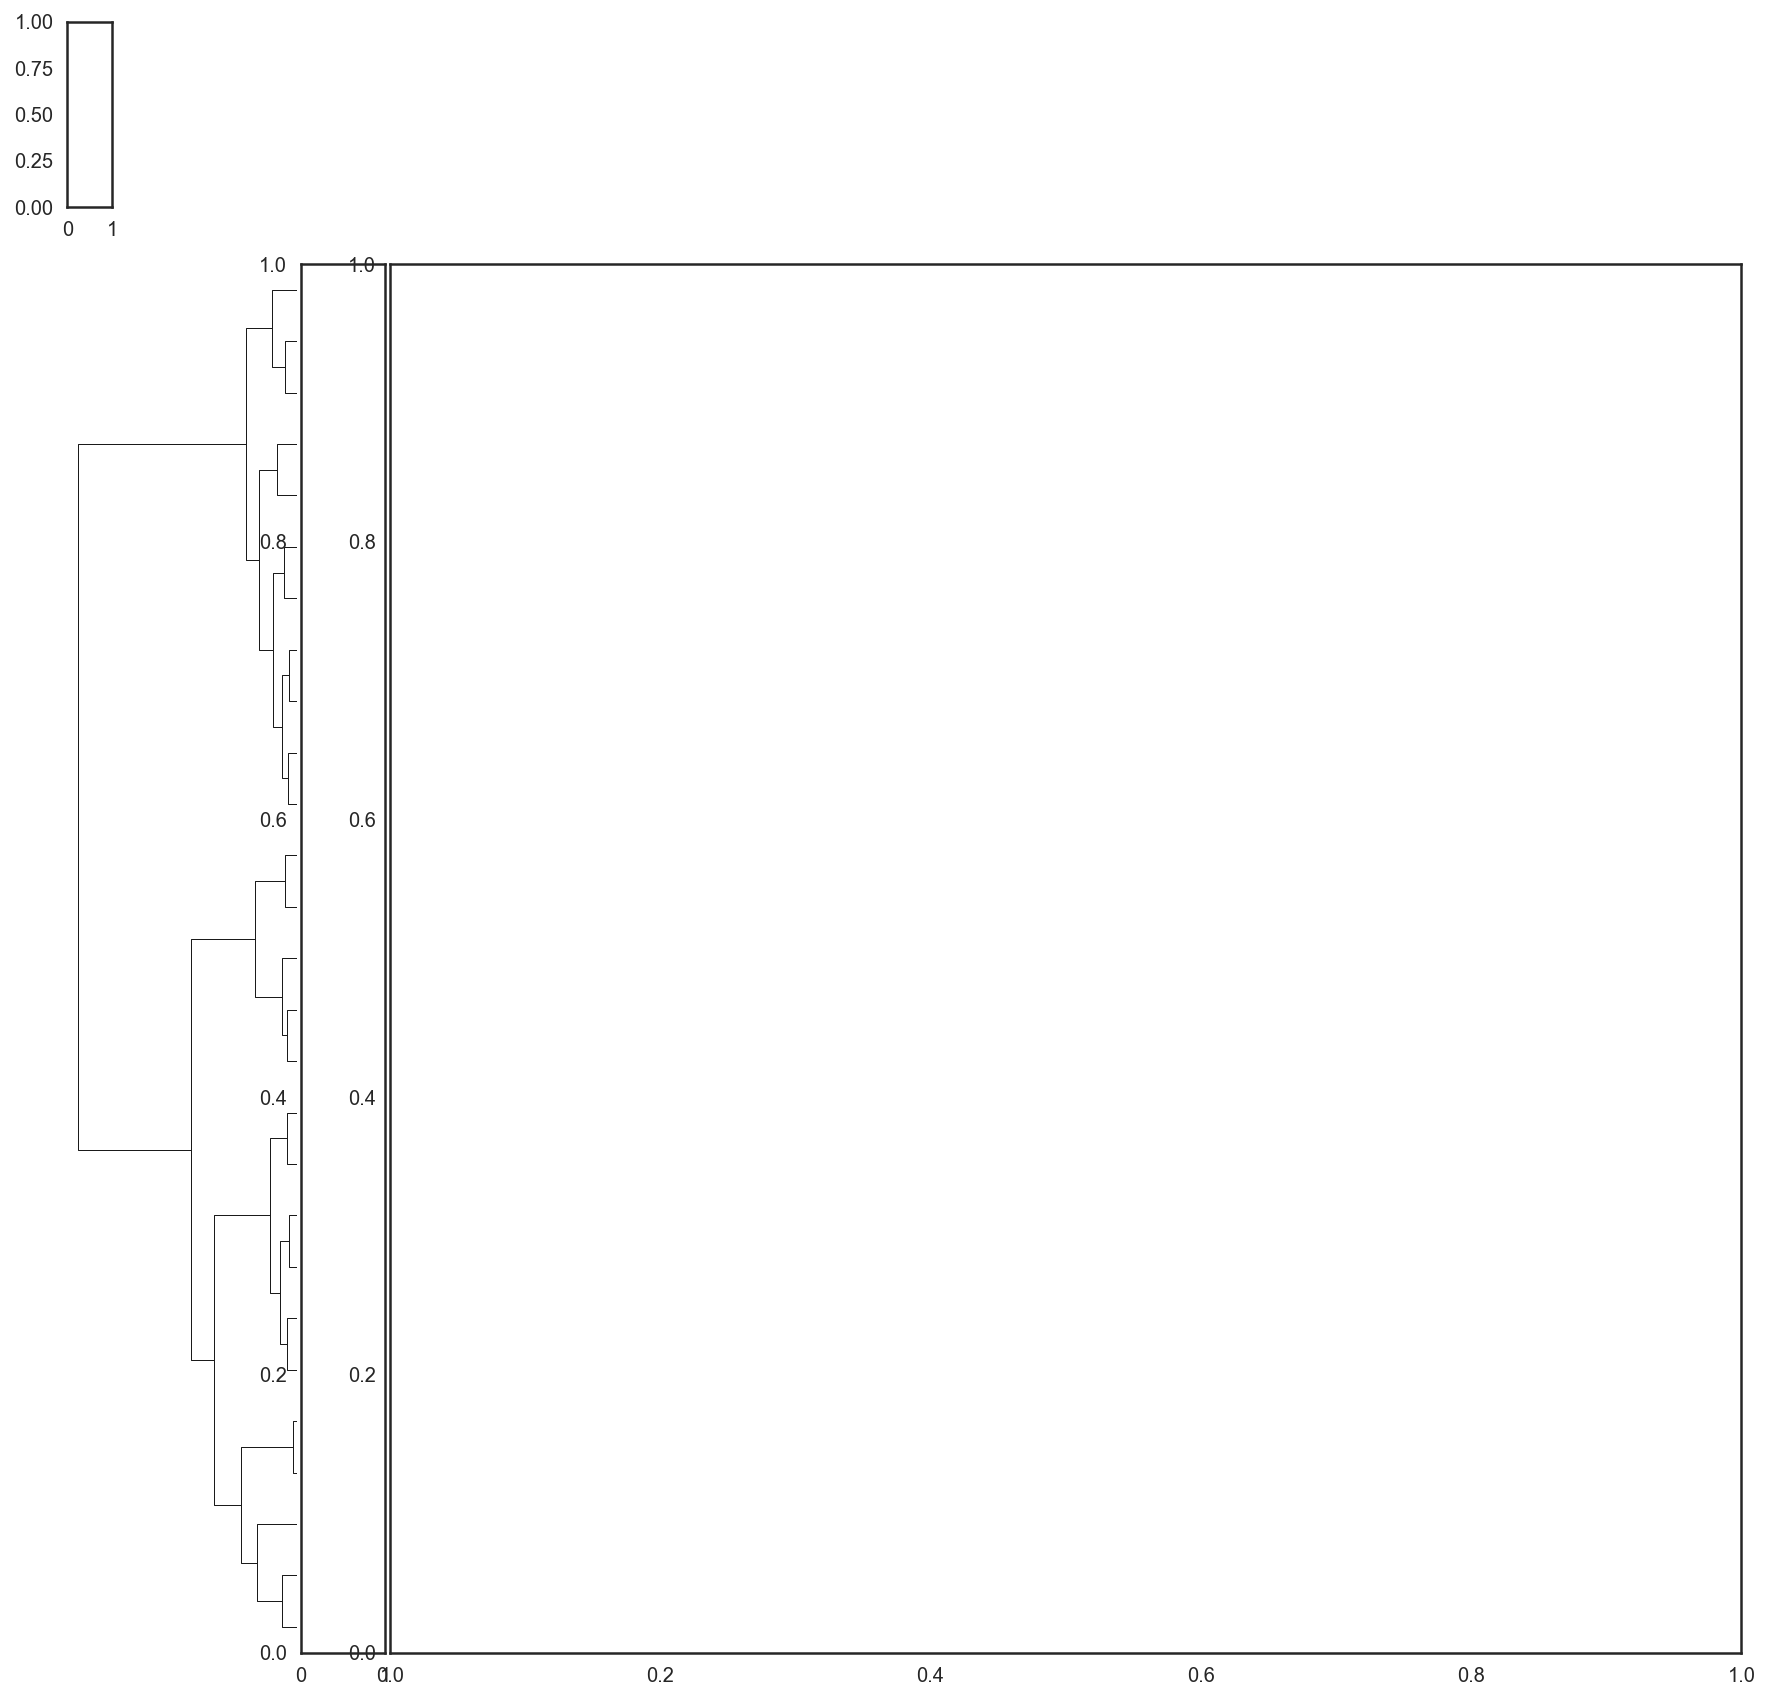

In [58]:
cycle_length = int(cycle_length)
print_heatmap2(timeSeries, user_cycle_df[user_cycle_df.user == 407], "all", metric, method, first_cycle = True)

plt.savefig('hr/407complete_braycurts_hr.png', bbox_inches='tight')



In [ ]:
#cycle_indeces cluster sorted
clustered_bray_complete = cluster_order(clusters, ts)

#heatmap of the original feature values sorted by clusters
heatmap_ordered(clustered_bray_complete, hr407_nan_md_cc, "rocket")
plt.savefig('hr/407complete_braycurts_hr_CLUSTER_.png', bbox_inches='tight')

### women with more than ten cycles

In [59]:
#data

#missing days interpolated
md = pd.read_csv("Data/missingdays_interpolated.csv")
#complete cycles
cc = pd.read_csv("Data/data_clean2.csv")


cc = cc.drop(["Unnamed: 0", "level_0", "br_stan","hr_stan","st_stan","index","date"], axis =1)
md = md.drop(["date.1","date"],axis =1)
df_regLen = pd.concat([cc,md], ignore_index = True)
groupby_cycles = df_regLen.groupby(["cycle_index","user","cycle_number"]).mean()
groupby_cycles
user_cycle_df = pd.DataFrame(groupby_cycles.reset_index()[["cycle_index", "user", "cycle_number", "cycle_length"]])

user_cycle_df["cycle_length"] = user_cycle_df["cycle_length"].astype(int)
user_cycle_df

df_ = df_regLen[(df_regLen.user == 407)|(df_regLen.user == 406)|(df_regLen.user == 500)|(df_regLen.user == 4070)|(df_regLen.user ==  470)|(df_regLen.user == 487)|(df_regLen.user == 500)|(df_regLen.user == 1316)]


hr_norm_zero, hr_norm_nan = cycle_transform(df_, "hr_norm", True)

hr_zero, hr_nan = cycle_transform(df_, "hr", True)


[18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 134, 135, 136, 137, 142, 144, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 183, 184, 185, 187, 188, 189, 190, 191, 192, 194, 285, 286, 287, 289, 295, 514, 515, 516, 517, 518, 519, 521, 522, 523, 524]
[18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 134, 135, 136, 137, 142, 144, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 183, 184, 185, 187, 188, 189, 190, 191, 192, 194, 285, 286, 287, 289, 295, 514, 515, 516, 517, 518, 519, 521, 522, 523, 524]


In [60]:
feature = "Heart Rate (z-score)"
%matplotlib inline
cycle_length = "all"
timeSeries = hr_norm_nan.fillna(0).T
k = 6
method = "complete"
metric = "braycurtis"
#plot_dendro(timeSeries, method, metric, k, feature, cycle_length)
clusters = plot_clustered_ts(timeSeries, k, method, metric, anim=True, plot = True)
plt.savefig("some women 406 407"+method+"-"+metric+" clustered cylces ("+str(cycle_length)+" Days).png")
clusters

NameError: name 'plot_clustered_ts' is not defined

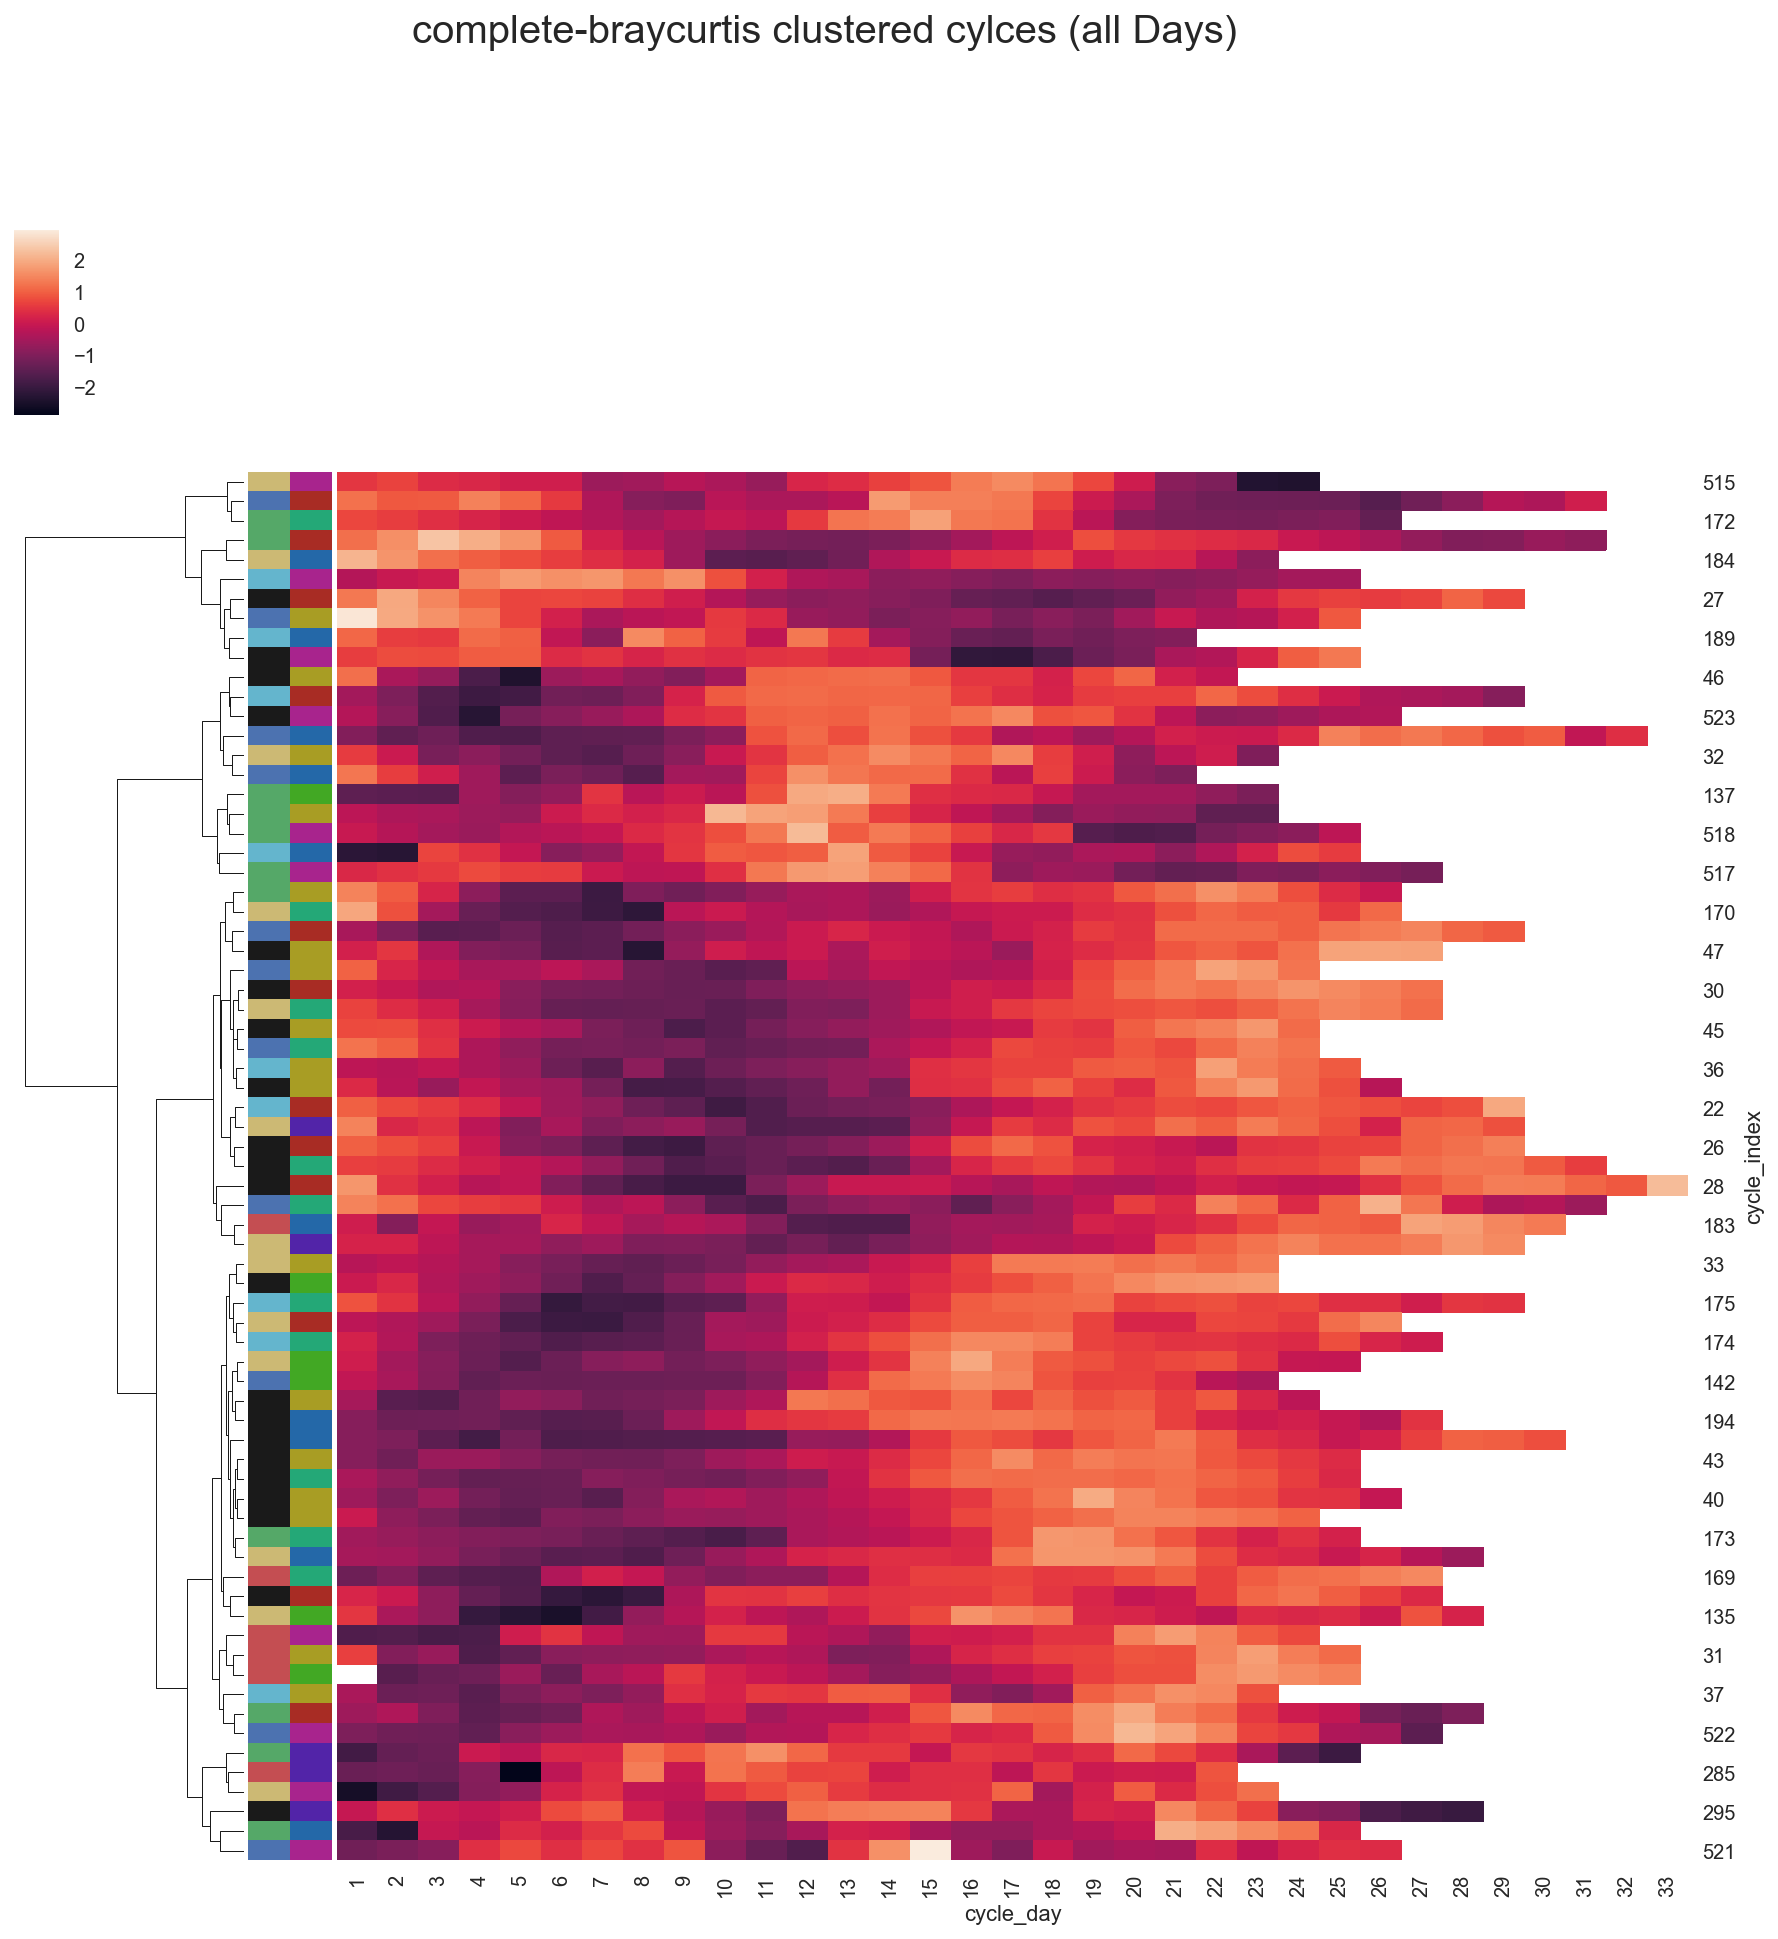

In [61]:
#cycle_length = int(cycle_length)
user_cycle_df = user_cycle_df[(user_cycle_df.user == 407)|(user_cycle_df.user == 406)|(user_cycle_df.user == 500)|(user_cycle_df.user == 4070)|(user_cycle_df.user ==  470)|(user_cycle_df.user == 487)|(user_cycle_df.user == 500)|(user_cycle_df.user == 1316)]

%matplotlib inline
print_heatmap2(hr_norm_nan.hr_norm.T, user_cycle_df, "all", metric, method, first_cycle = True)

plt.savefig('hr/first/some_women_406 407 complete_braycurts_hr.png', bbox_inches='tight')

In [62]:
#cycle_indeces cluster sorted
clustered_bray_complete = cluster_order(clusters, hr_norm_zero.hr_norm.T)

#heatmap of the original feature values sorted by clusters
heatmap_ordered(clustered_bray_complete, hr_nan.hr.T, "rocket")
plt.savefig('hr/some_women 406 407_complete_braycurts_hr_CLUSTER_.png', bbox_inches='tight')

NameError: name 'clusters' is not defined

### first five

Using matplotlib backend: MacOSX


/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


array([2, 4, 2, 4, 2, 2, 4, 3, 4, 3, 2, 2, 2, 3, 2, 3, 2, 2, 2, 4, 3, 2, 2,
       2, 2, 2, 4, 2, 3, 2, 2, 2, 1, 2, 2, 2, 3, 3, 4, 2, 2, 3, 3, 4, 4, 2,
       2, 4, 2, 1, 1, 4, 3, 2, 2, 2, 2, 3, 2, 1, 5, 1, 4, 1, 4, 2, 6, 1, 2,
       2, 4], dtype=int32)

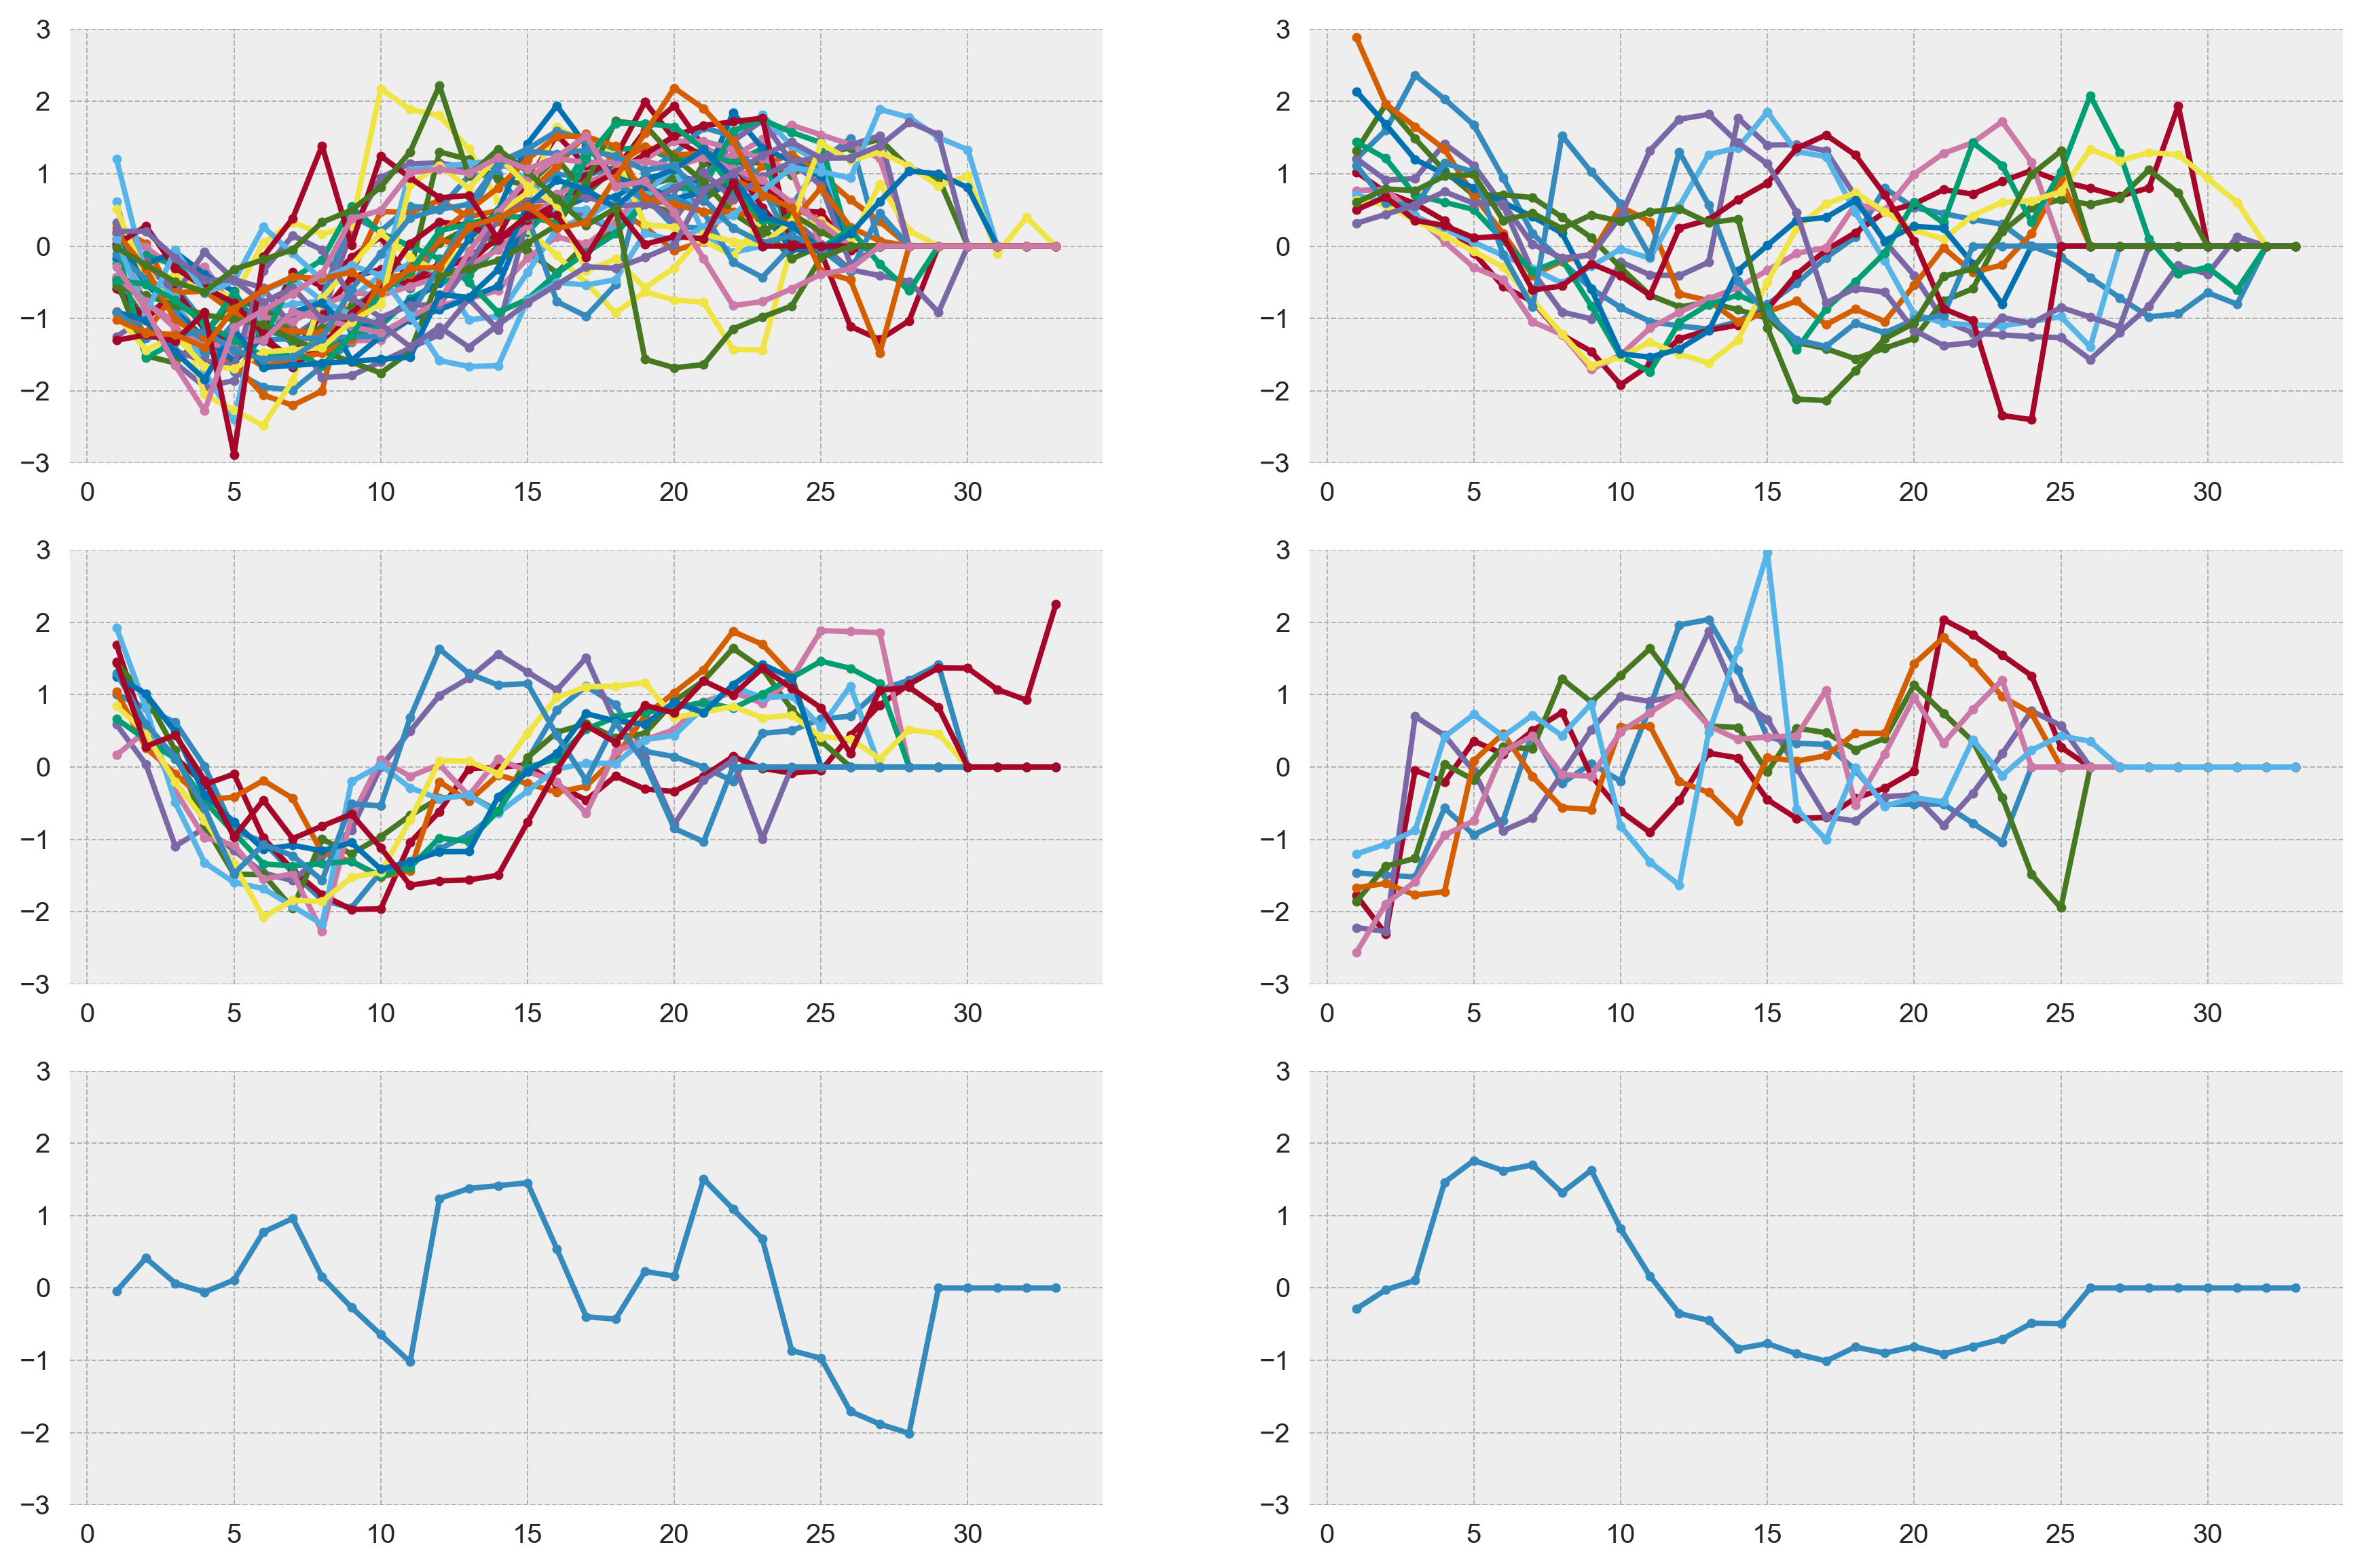

In [63]:
feature = "Heart Rate (z-score)"
%matplotlib inline
cycle_length = "all"
timeSeries = hr_norm_nan.fillna(0).T
k = 6
method = "complete"
metric = "braycurtis"
#plot_dendro(timeSeries, method, metric, k, feature, cycle_length)
clusters = plot_clustered_ts_part(timeSeries, k, method, metric, 5,anim=True, plot = True)
plt.savefig("hr/first/some women first5"+method+"-"+metric+" clustered cylces ("+str(cycle_length)+" Days).png")
clusters

IndexError: index 62 is out of bounds for axis 1 with size 9

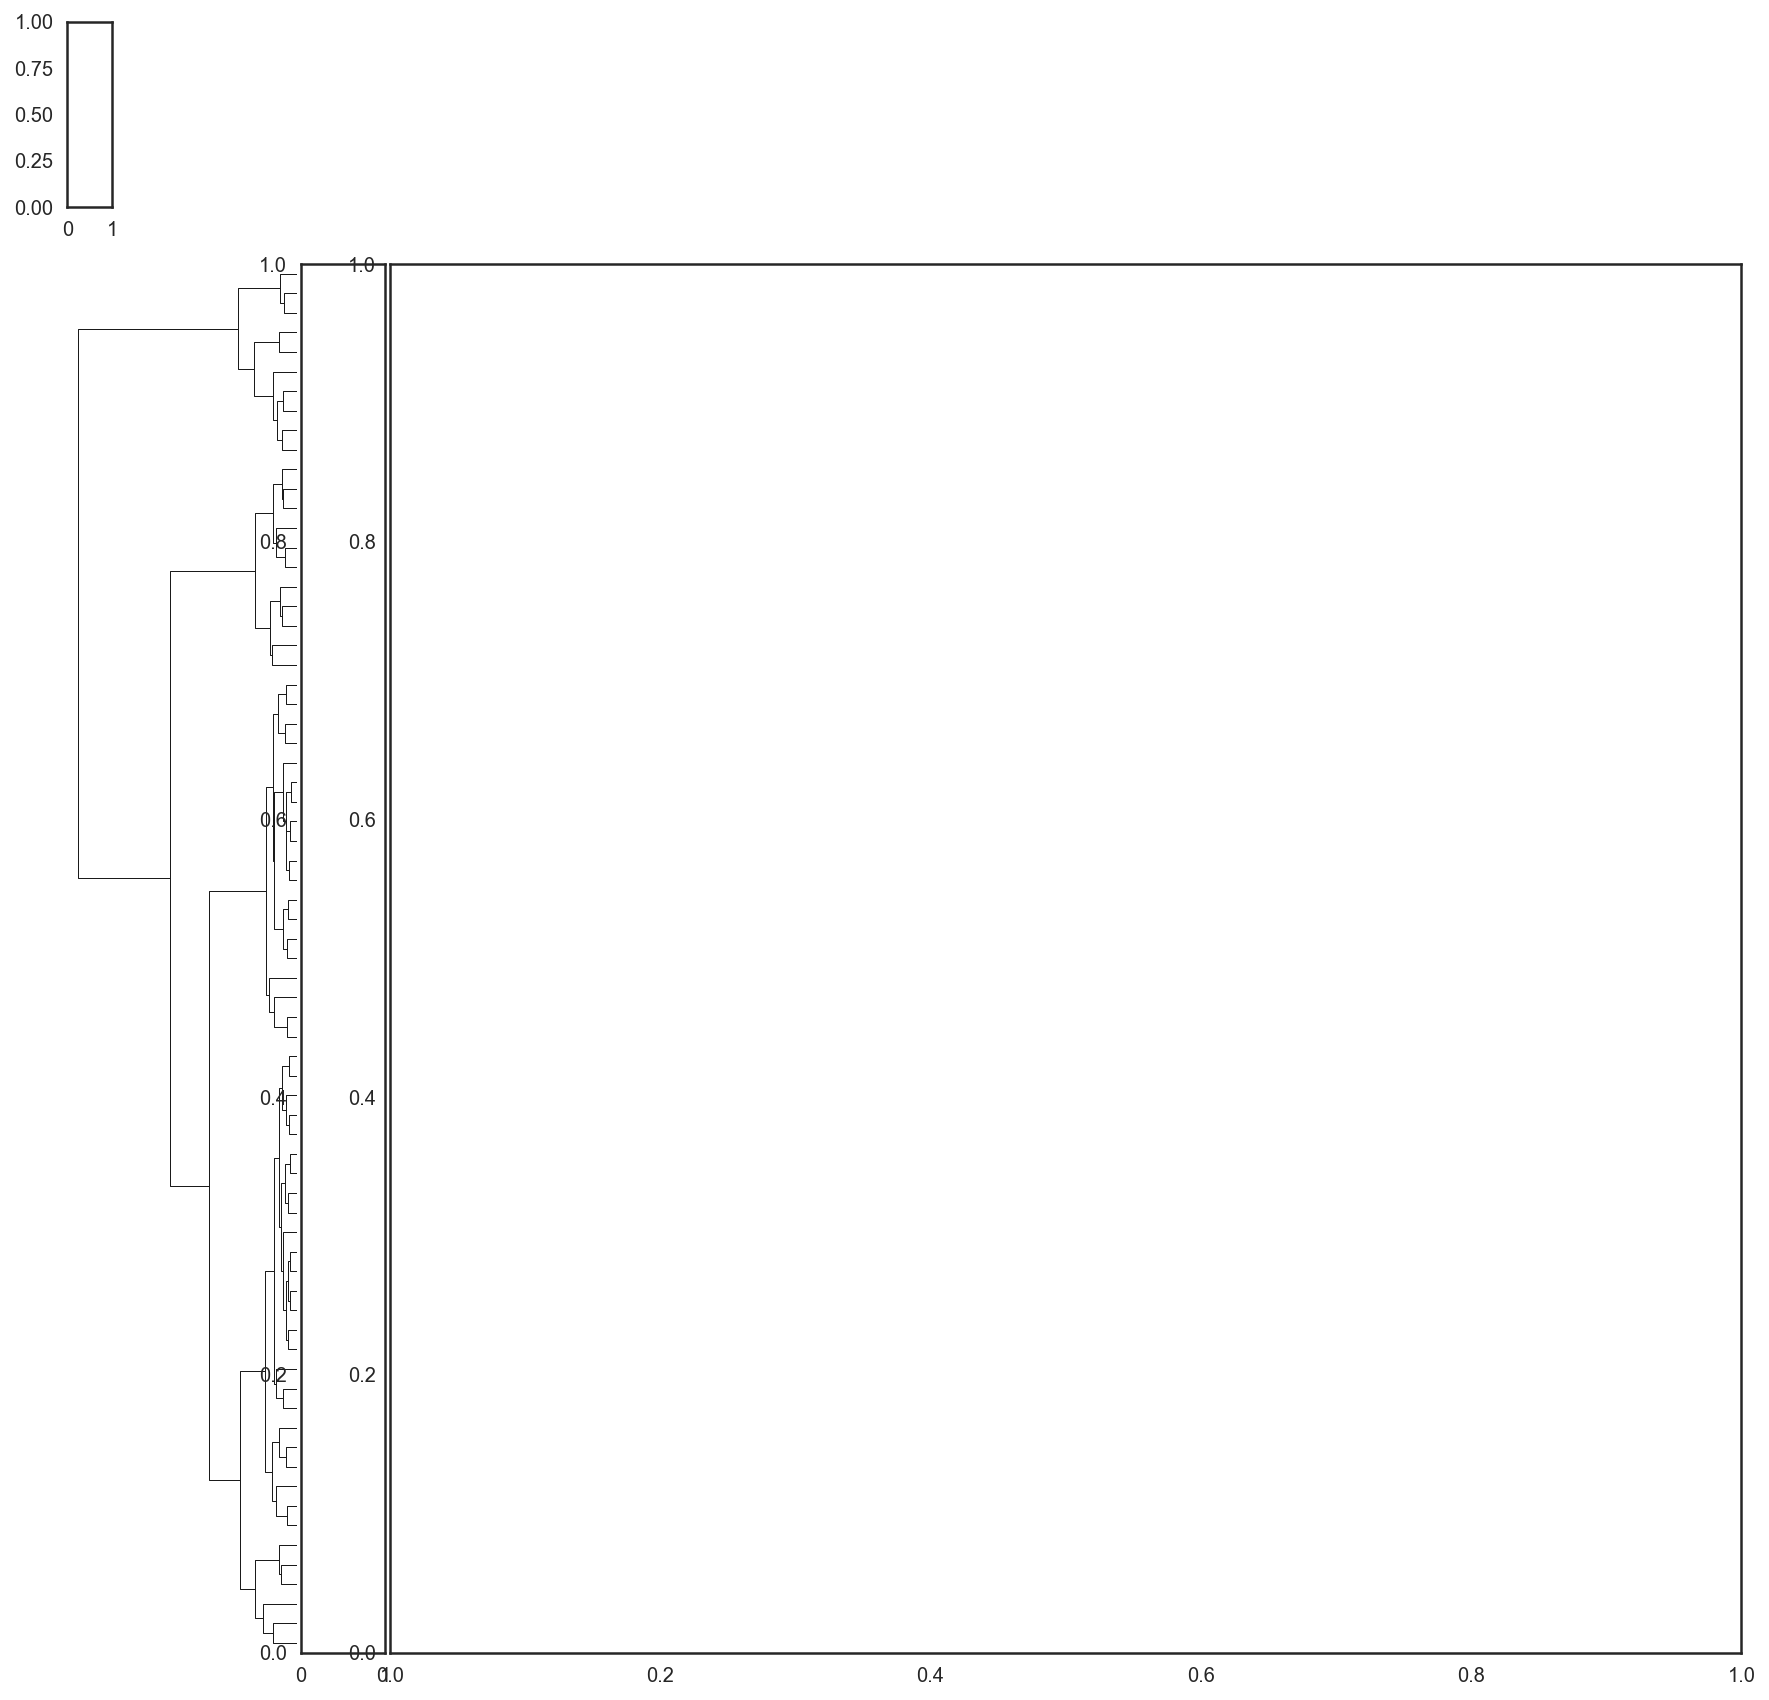

In [66]:
#cycle_length = int(cycle_length)
user_cycle_df = user_cycle_df[(user_cycle_df.cycle_length == 29)]



%matplotlib inline
print_heatmap2(hr_norm_nan.hr_norm.T, user_cycle_df, 29, metric, method, first_cycle = True)

plt.savefig('hr/first/some women first5_complete_braycurts_hr.png', bbox_inches='tight')

In [28]:
#cycle_indeces cluster sorted
clustered_bray_complete = cluster_order(clusters, hr_norm_zero.hr_norm.T)

#heatmap of the original feature values sorted by clusters
heatmap_ordered(clustered_bray_complete, hr_norm_nan.hr_norm.T, "rocket")
plt.savefig('hr/first/some_women_first5_complete_braycurts_hr_CLUSTER_.png', bbox_inches='tight')

NameError: name 'clusters' is not defined

## + second five

In [29]:
feature = "Heart Rate (z-score)"
%matplotlib inline
cycle_length = "all"
timeSeries = hr_norm_nan.fillna(0).T
k = 6
method = "complete"
metric = "braycurtis"
#plot_dendro(timeSeries, method, metric, k, feature, cycle_length)
clusters = plot_clustered_ts_part(timeSeries, k, method, metric, 10,anim=True, plot = True)
plt.savefig("hr/first/some women first10"+method+"-"+metric+" clustered cylces ("+str(cycle_length)+" Days).png")
clusters

#cycle_length = int(cycle_length)
user_cycle_df = user_cycle_df[(user_cycle_df.user == 407)|(user_cycle_df.user == 406)|(user_cycle_df.user == 500)|(user_cycle_df.user == 4070)|(user_cycle_df.user ==  470)|(user_cycle_df.user == 487)|(user_cycle_df.user == 500)|(user_cycle_df.user == 1316)]



%matplotlib inline
print_heatmap2(hr_norm_nan.hr_norm.T, user_cycle_df, "all", metric, method, first_cycle = True)

plt.savefig('hr/first/some women first10_complete_braycurts_hr.png', bbox_inches='tight')

#cycle_indeces cluster sorted
clustered_bray_complete = cluster_order(clusters, hr_norm_zero.hr_norm.T)

#heatmap of the original feature values sorted by clusters
heatmap_ordered(clustered_bray_complete, hr_nan.hr.T, "rocket")
plt.savefig('hr/first/some_women_first10_complete_braycurts_hr_CLUSTER_.png', bbox_inches='tight')

NameError: name 'plot_clustered_ts_part' is not defined

### + third five

In [30]:
feature = "Heart Rate (z-score)"
%matplotlib inline
cycle_length = "all"
timeSeries = hr_norm_nan.fillna(0).T
k = 6
method = "complete"
metric = "braycurtis"
#plot_dendro(timeSeries, method, metric, k, feature, cycle_length)
clusters = plot_clustered_ts_part(timeSeries, k, method, metric, 15,anim=True, plot = True)
plt.savefig("hr/first/some women first15"+method+"-"+metric+" clustered cylces ("+str(cycle_length)+" Days).png")
clusters

#cycle_length = int(cycle_length)
user_cycle_df = user_cycle_df[(user_cycle_df.user == 407)|(user_cycle_df.user == 406)|(user_cycle_df.user == 500)|(user_cycle_df.user == 4070)|(user_cycle_df.user ==  470)|(user_cycle_df.user == 487)|(user_cycle_df.user == 500)|(user_cycle_df.user == 1316)]



%matplotlib inline
print_heatmap2(hr_norm_nan.hr_norm.T, user_cycle_df, "all", metric, method, first_cycle = True)

plt.savefig('hr/first/some women first15_complete_braycurts_hr.png', bbox_inches='tight')

#cycle_indeces cluster sorted
clustered_bray_complete = cluster_order(clusters, hr_norm_zero.hr_norm.T)

#heatmap of the original feature values sorted by clusters
heatmap_ordered(clustered_bray_complete, hr_norm_nan.hr_norm.T, "rocket")
plt.savefig('hr/first/some_women_first15_complete_braycurts_hr_CLUSTER_.png', bbox_inches='tight')

NameError: name 'plot_clustered_ts_part' is not defined

### PCA

In [31]:
#data

#missing days interpolated
#complete cycles
cc = pd.read_csv("Data/data_clean_pca.csv")


cc = cc.drop(["Unnamed: 0", "br_stan","hr_stan","st_stan","index","date"], axis =1)
#md = md.drop(["date.1","date"],axis =1)
df_regLen = cc
groupby_cycles = df_regLen.groupby(["cycle_index","user","cycle_number"]).mean()
groupby_cycles
user_cycle_df = pd.DataFrame(groupby_cycles.reset_index()[["cycle_index", "user", "cycle_number", "cycle_length"]])

user_cycle_df["cycle_length"] = user_cycle_df["cycle_length"].astype(int)
user_cycle_df

df_ = df_regLen
print(df_)


hr_norm_zero, hr_norm_nan = cycle_transform(df_, "PCA", True)

hr_zero, hr_nan = cycle_transform(df_, "hr", True)
hr_norm_zero_, hr_norm_nan_ = cycle_transform(df_, "hr_norm", True)


      Unnamed: 0.1   user  first_date   last_date  cycle_number  cycle_length  \
0               56    360  2016-09-08  2016-10-11             1            34   
1               57    360  2016-09-08  2016-10-11             1            34   
2               58    360  2016-09-08  2016-10-11             1            34   
3               59    360  2016-09-08  2016-10-11             1            34   
4               60    360  2016-09-08  2016-10-11             1            34   
5               61    360  2016-09-08  2016-10-11             1            34   
6               62    360  2016-09-08  2016-10-11             1            34   
7               63    360  2016-09-08  2016-10-11             1            34   
8               64    360  2016-09-08  2016-10-11             1            34   
9               65    360  2016-09-08  2016-10-11             1            34   
10              66    360  2016-09-08  2016-10-11             1            34   
11              67    360  2

In [32]:
feature = "Heart Rate (z-score)"
%matplotlib inline
cycle_length = "all"
timeSeries = hr_norm_nan.fillna(0).T
k = 6
method = "complete"
metric = "braycurtis"
#plot_dendro(timeSeries, method, metric, k, feature, cycle_length)
clusters = plot_clustered_ts(timeSeries, k, method, metric, anim=True, plot = True)
plt.savefig("pca_cc"+method+"-"+metric+" clustered cylces ("+str(cycle_length)+" Days).png")
clusters

NameError: name 'plot_clustered_ts' is not defined

In [33]:
#cycle_length = int(cycle_length)
user_cycle_df = user_cycle_df
%matplotlib inline
print_heatmap2(hr_norm_nan.PCA.T, user_cycle_df, "all", metric, method, first_cycle = True)

plt.savefig('hr/first/pca_cc_complete_braycurts_hr.png', bbox_inches='tight')

NameError: name 'print_heatmap2' is not defined

### HR clustered by PCA

In [34]:
#cycle_indeces cluster sorted
clustered_bray_complete = cluster_order(clusters, hr_norm_zero.PCA.T)

#heatmap of the original feature values sorted by clusters
heatmap_ordered(clustered_bray_complete, hr_nan.hr.T, "rocket")
plt.savefig('hr/first/some_women_first5_complete_braycurts_hr_CLUSTER_.png', bbox_inches='tight')

NameError: name 'clusters' is not defined

### HR Norm clustered by PCA 

In [35]:
#cycle_indeces cluster sorted
clustered_bray_complete = cluster_order(clusters, hr_norm_zero.PCA.T)

#heatmap of the original feature values sorted by clusters
heatmap_ordered(clustered_bray_complete, hr_norm_nan_.hr_norm.T, "rocket")
plt.savefig('hr/first/some_women_first5_complete_braycurts_hr_norm_CLUSTER_.png', bbox_inches='tight')

NameError: name 'clusters' is not defined